# DS4400 Final Project Source Code

Zach O'Brien

December 2022

# 0. Set up Development Environment

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import sklearn.linear_model as linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from preprocessing import preprocess_bikeshare_data

# 1. Data Preparation

In [72]:
data_file = "data/day.csv"
df = pd.read_csv(data_file)
df.head(3)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349


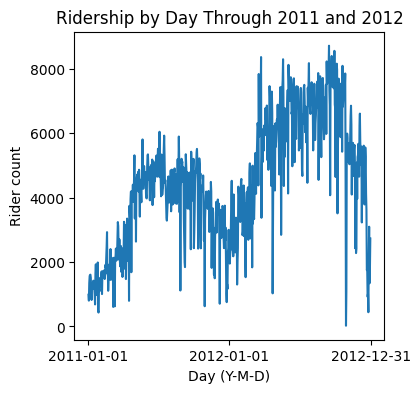

In [73]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(df["cnt"])
ax.set_xlabel("Day (Y-M-D)")
ax.set_ylabel("Rider count")
ax.set_title("Ridership by Day Through 2011 and 2012")
ax.set_xticks([0, len(df)//2, len(df)], labels=df["dteday"][[0, len(df)//2, len(df)-1]])
plt.show()

In [92]:
df[["cnt"]].describe()

,cnt
count,731.000000
mean,4504.348837
std,1937.211452
min,22.000000
25%,3152.000000
50%,4548.000000
75%,5956.000000
max,8714.000000


In [74]:
# Define which columns we want to keep for model training
categorical_columns = ["season", "holiday", "weekday", "workingday", "weathersit"]
continuous_columns = ["temp", "atemp", "hum", "windspeed"]
feature_columns = categorical_columns + continuous_columns
label_column = "cnt"
# Only keep features and target
df = df[feature_columns + [label_column]]

In [75]:
# Preprocess the data by one-hot encoding the categorical features
# and MinMaxScale-ing the label, because it will also be used as a feature (the previous day's count)
preprocessed_df, label_scaler = preprocess_bikeshare_data(df, categorical_cols=categorical_columns, label_col=label_column)
preprocessed_df.describe()

,season_1,season_2,season_3,season_4,holiday_0,holiday_1,weekday_0,weekday_1,weekday_2,weekday_3,...,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,temp,atemp,hum,windspeed,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,...,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.247606,0.251710,0.257182,0.243502,0.971272,0.028728,0.143639,0.143639,0.142271,0.142271,...,0.316005,0.683995,0.633379,0.337893,0.028728,0.495385,0.474354,0.627894,0.190486,0.515687
std,0.431917,0.434293,0.437380,0.429489,0.167155,0.167155,0.350963,0.350963,0.349567,0.349567,...,0.465233,0.465233,0.482212,0.473316,0.167155,0.183051,0.162961,0.142429,0.077498,0.222873
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.059130,0.079070,0.000000,0.022392,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.337083,0.337842,0.520000,0.134950,0.360101
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.498333,0.486733,0.626667,0.180975,0.520709
75%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.655417,0.608602,0.730209,0.233214,0.682697
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.861667,0.840896,0.972500,0.507463,1.000000


# 2. Non-LSTM Model Training

## 2.1 Create Cross Validation Data for All Models Except LSTM Model

The LSTM model will be trained on hourly data instead of daily data to predict the next day's count. So, its data preparation will be a little different.

In [76]:
X = preprocessed_df.iloc[:-1, :].to_numpy()
y = preprocessed_df[[label_column]].iloc[1:, :].to_numpy()

print(f"Inputs have shape: {inputs.shape}")
print(f"Labels have shape: {labels.shape}")

Inputs have shape: (730, 23)
Labels have shape: (730, 1)


In [86]:
timeseries_crossval = TimeSeriesSplit(n_splits=5)
crossval_indices = list(timeseries_crossval.split(X))

## 2.2 Evaluate Naive Baseline Model

In [67]:
def baseline_model(input_vectors, cnt_col):
    """A naive model which simply uses the previous day's count
       as the prediction for today"""
    return input_vectors[:, cnt_col]

In [93]:
# The column with the previous day's count is the last item in the vector
RIDERSHIP_COUNT_IDX = X.shape[1] - 1  

# Record root mean squared error for each cross validation set
rmse_scores_baseline = []
for train_indices, test_indices in crossval_indices:
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    baseline_predictions = baseline_model(X_test, cnt_col=RIDERSHIP_COUNT_IDX)
    rmse_scores_baseline.append(mean_squared_error(y_test, baseline_predictions, squared=False))

# The count was MinMaxScaled to use in model training. But for better interpretability of
# the results, it is transformed back to its original value here
avg_rmse_score_baseline = label_scaler.inverse_transform(np.average(rmse_scores_baseline).reshape(-1, 1))
print("Average RMSE for Naive Baseline Model:")
print(avg_rmse_score_baseline)

Average RMSE for Naive Baseline Model:
[[1116.73745878]]


## 2.3 Evaluate Linear and Ridge Regression Models

In [64]:
linear_regressor = linear_model.LinearRegression().fit(X_train, y_train)
linear_regressor.fit(X_train, y_train)
model_predictions = linear_regressor.predict(X_test)
linear_rmse = label_scaler.inverse_transform(mean_squared_error(y_test, model_predictions, squared=False).reshape(-1, 1))

In [29]:
for alpha in [0.01, 0.1, 1, 10, 100]:
    ridge_regressor = linear_model.Ridge(alpha=alpha)
    ridge_regressor.fit(X_train, y_train)
    model_predictions = ridge_regressor.predict(X_test)
    print(mean_squared_error(y_test, model_predictions, squared=False))

0.13970207209779806
0.14055841054692456
0.14534238755569487
0.18216024840038647
0.24585995175754788


Text(0, 0.5, 'Prediction')

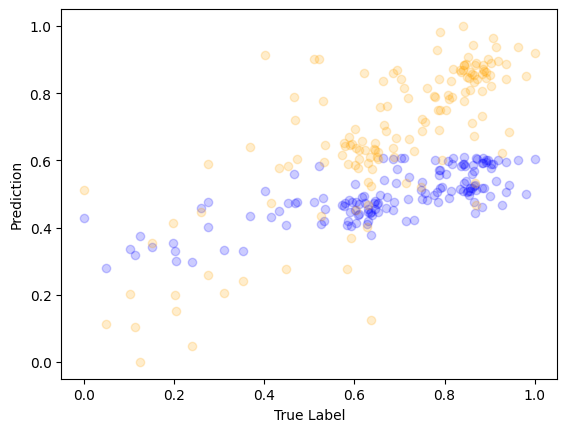

In [33]:
fig, ax = plt.subplots()

ax.scatter(y_test, model_predictions, alpha=0.2, color="blue")
ax.scatter(y_test, baseline_predictions, alpha=0.2, color="orange")
ax.set_xlabel("True Label")
ax.set_ylabel("Prediction")

In [39]:
import torch
from torch.utils.data import DataLoader

from nn_dataprep import BikeshareDataset

In [40]:
train_data = BikeshareDataset(X_train, y_train)
test_data = BikeshareDataset(X_test, y_test)

In [41]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [17]:
from torch import nn

In [18]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(24, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [19]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [20]:
learning_rate = .01
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    error = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).numpy()
            error += mean_squared_error(y.numpy(), pred, squared=False)
            
    error /= num_batches
    print(f"Test RMAE: {error}")

In [22]:
epochs = 500
for t in range(epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer)
    if t % 100 == 0:
        print(t)
        test_loop(test_dataloader, model, loss_fn)
print("Done!")


0
Test RMAE: 0.22270232872529463
100
Test RMAE: 0.20476406826214358
200
Test RMAE: 0.20299160168929534
300
Test RMAE: 0.2007989011027596
400
Test RMAE: 0.19849076203324578
Done!


In [43]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress tensorflow debugging info

In [44]:
import keras
from keras.utils import timeseries_dataset_from_array
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam, SGD

In [45]:
SEQUENCE_LENGTH_HRS = 48
SAMPLING_RATE=1
BATCH_SIZE=64
FEATURE_VEC_SIZE = 24
LEARNING_RATE=0.01

In [46]:
inputs = preprocessed_df.iloc[:-SEQUENCE_LENGTH_HRS, :].to_numpy()
labels = preprocessed_df[[label_column]].iloc[SEQUENCE_LENGTH_HRS:, :].to_numpy()

train_set_size = 8_000

X_train = inputs[:train_set_size]
y_train = labels[:train_set_size]
X_test = inputs[train_set_size:]
y_test = labels[:train_set_size]

train_dataset = timeseries_dataset_from_array(
    data=X_train,
    targets=y_train,
    sampling_rate=SAMPLING_RATE,
    sequence_length=SEQUENCE_LENGTH_HRS,
    batch_size=BATCH_SIZE)

validation_dataset = timeseries_dataset_from_array(
    data=X_test,
    targets=y_test,
    sampling_rate=SAMPLING_RATE,
    sequence_length=SEQUENCE_LENGTH_HRS,
    batch_size=BATCH_SIZE)

(8000, 24)
(9331, 24)


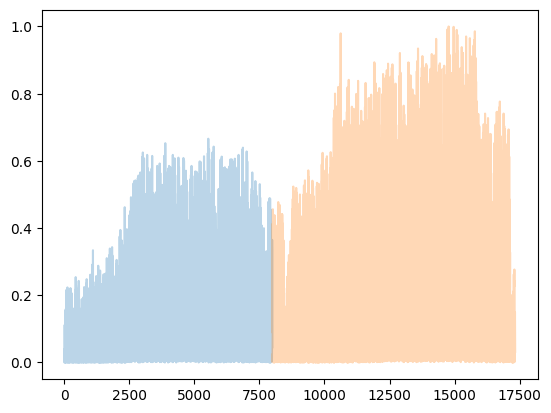

In [48]:
print(X_train.shape)
print(X_test.shape)

fig, ax = plt.subplots()

ax.plot(X_train[:, -1], alpha=0.3)
ax.plot(range(train_set_size, len(X_train) + len(X_test)), X_test[:, -1], alpha=0.3)

In [49]:
model = Sequential()
model.add(keras.Input(shape=(SEQUENCE_LENGTH_HRS, FEATURE_VEC_SIZE)))  # `None` indicates the sequence is of arbitrary length
model.add(LSTM(64))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer=SGD(learning_rate=LEARNING_RATE),
              loss="mean_squared_error", 
              metrics=["mae"])
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                22784     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 22,849
Trainable params: 22,849
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
125/125 [==============================] - 7s 40ms/step - loss: 0.0360 - mae: 0.1512 - val_loss: 0.0747 - val_mae: 0.2157
Epoch 2/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0306 - mae: 0.1386 - val_loss: 0.0459 - val_mae: 0.1580
Epoch 3/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0267 - mae: 0.1288 - val_loss: 0.0312 - val_mae: 0.1305
Epoch 4/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0248 - mae: 0.1244 - val_loss: 0.0238 - val_mae: 0.1203
Epoch 5/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0234 - mae: 0.1203 - val_loss: 0.0213 - val_mae: 0.1185
Epoch 6/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0224 - mae: 0.1177 - val_loss: 0.0207 - val_mae: 0.1175
Epoch 7/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0219 - mae: 0.1167 - val_loss: 0.0206 - val_mae: 0.1173
Epoch 8/10
125/125 [==============================] - 4s 35ms/step - 

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

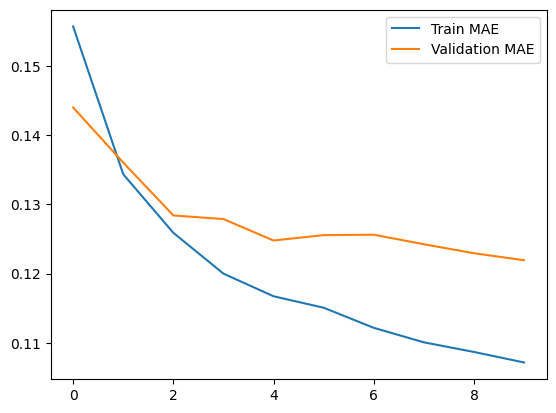

In [30]:
fig, ax = plt.subplots()

ax.plot(history.history["mae"], label="Train MAE")
ax.plot(history.history["val_mae"], label="Validation MAE")
ax.legend()
history.history.keys()